In [541]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from ast import literal_eval
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import re
from operator import add
import os

In [542]:
number_of_players =1
moving_average_window = 25
color_palette = ['-b', '-g', 'tab:orange', '-c', '-m', '-y' , '-k', '-w'] 
goal_frequency_window = 20
frequency_window = 10

In [543]:
train_dir = os.getcwd() + '/training_sessions/'
training_dir_list = [x[0] for x in sorted([(fn, os.stat(train_dir + fn)) for fn in os.listdir(train_dir)], key = lambda x: x[1].st_ctime)]
training_path = train_dir + training_dir_list[-1]
print(training_dir_list)
print(training_path)

['.ipynb_checkpoints', '12_22_13_1_vs_1', '12_22_14_1_vs_1']
/home/andrew/Git/Robocup-Sigma/maddpg-pytorch/training_sessions/12_22_14_1_vs_1


number of episodes finished 15621
number of time-steps finished 7810500
OutOfTime        6653
OutOfBounds      4721
Goal_By_Left     2906
Goal_By_Right    1341
Name: why, dtype: int64


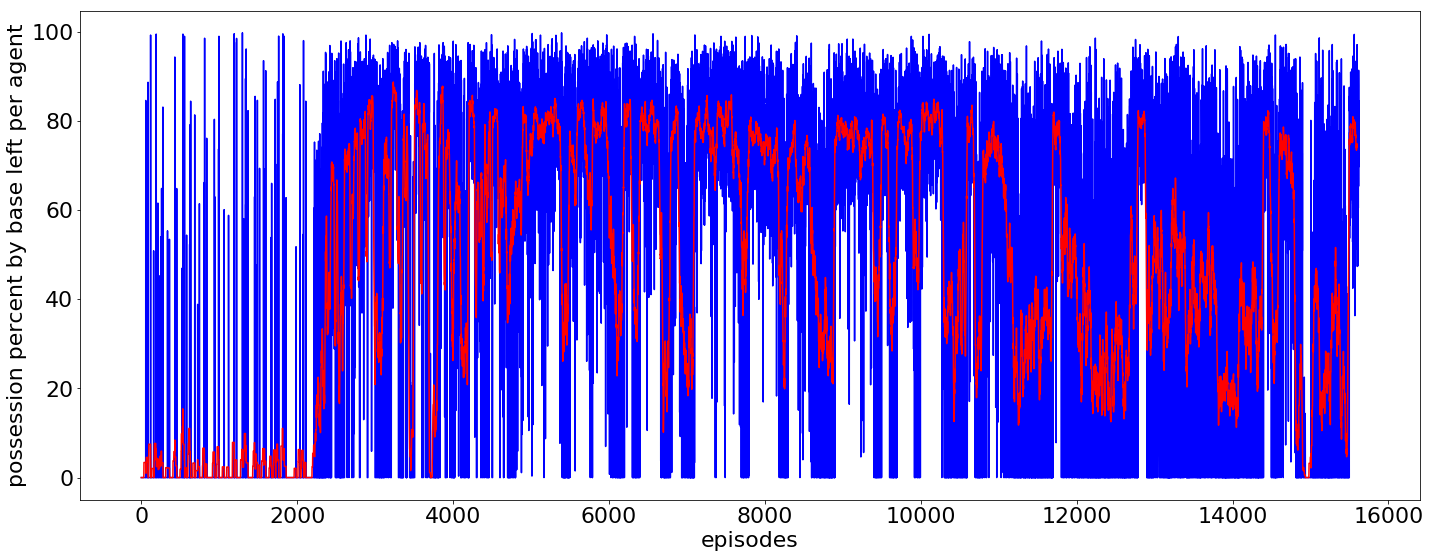

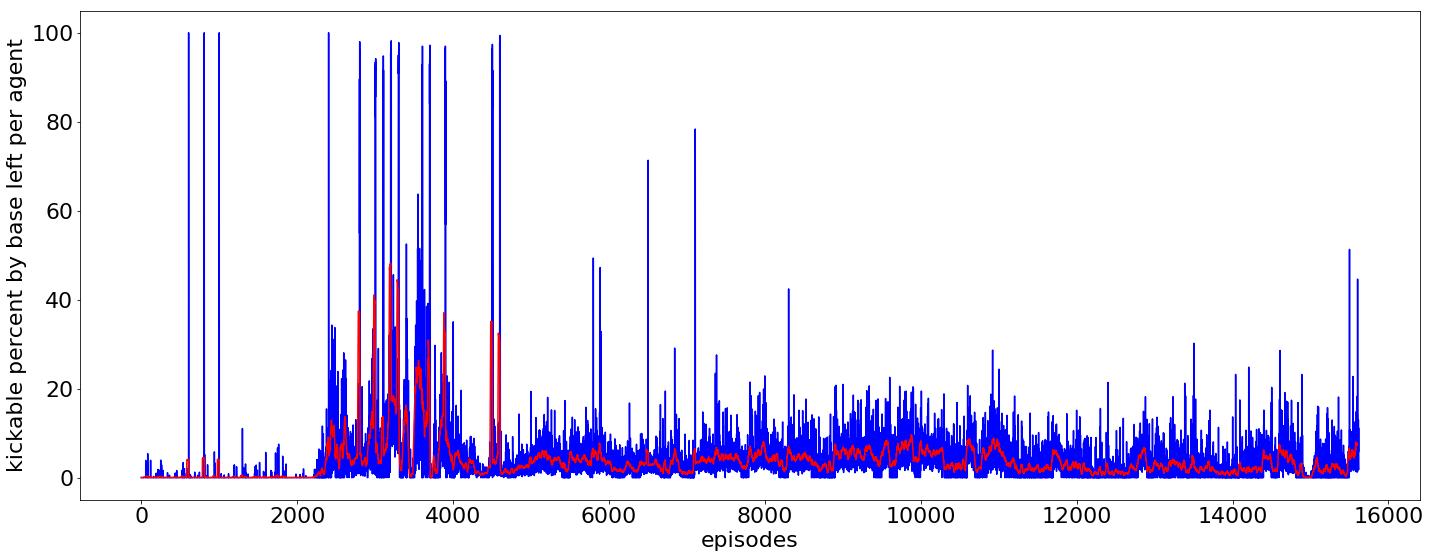

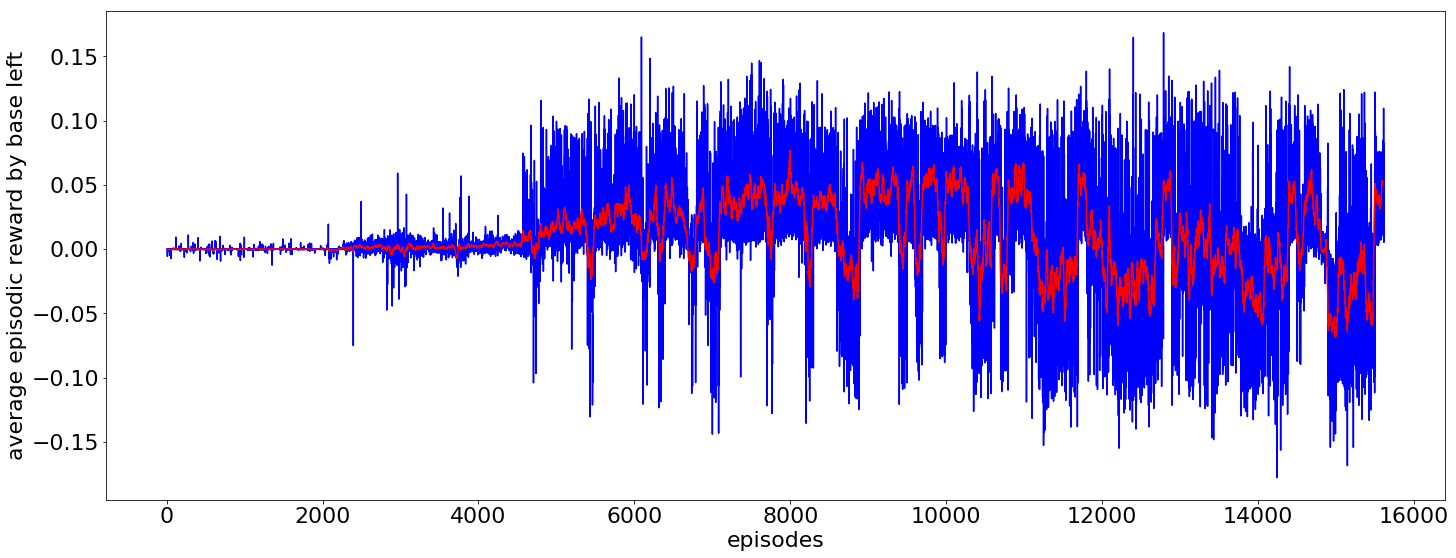

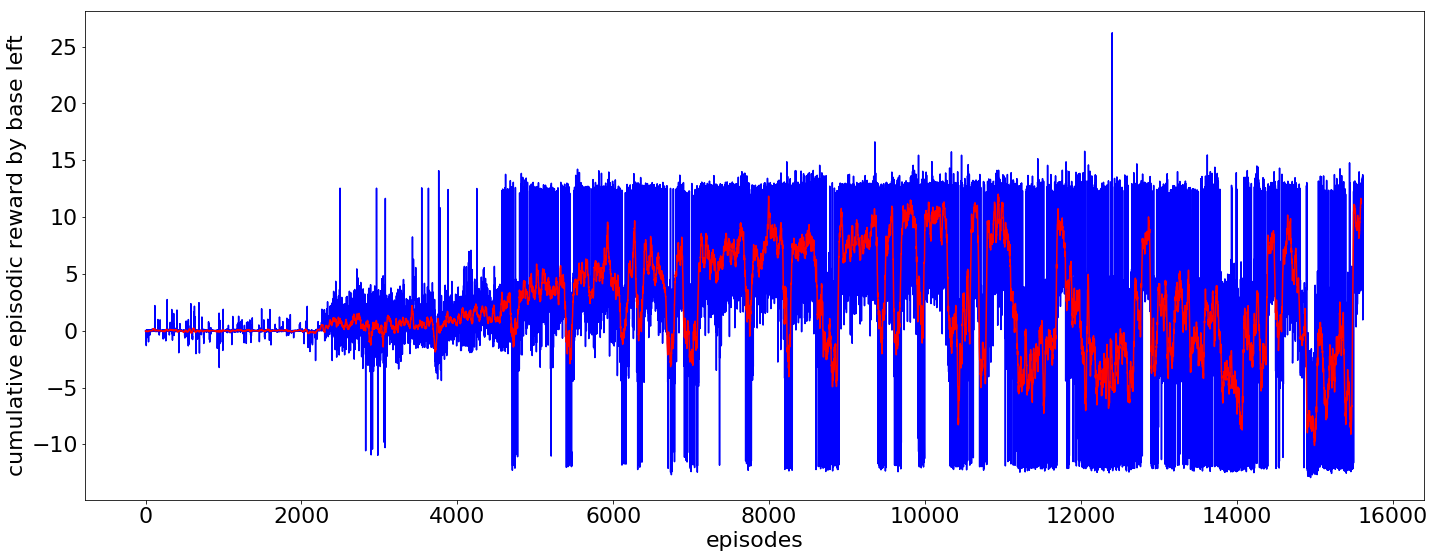

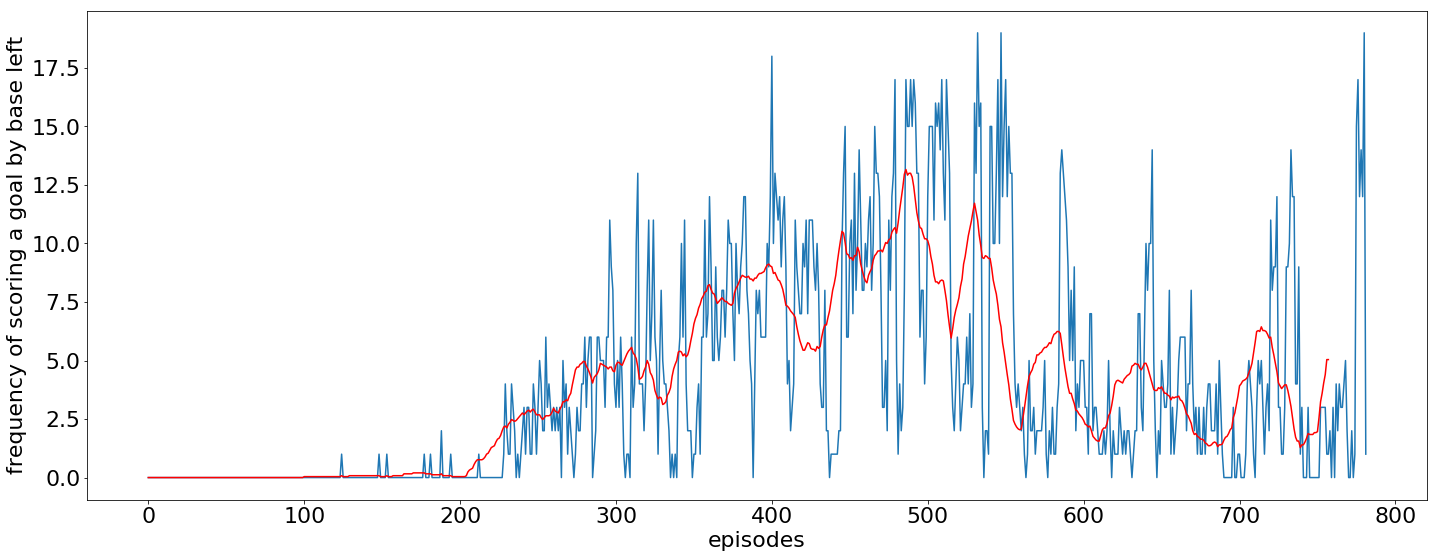

number of episodes finished 15625
number of time-steps finished 7812500


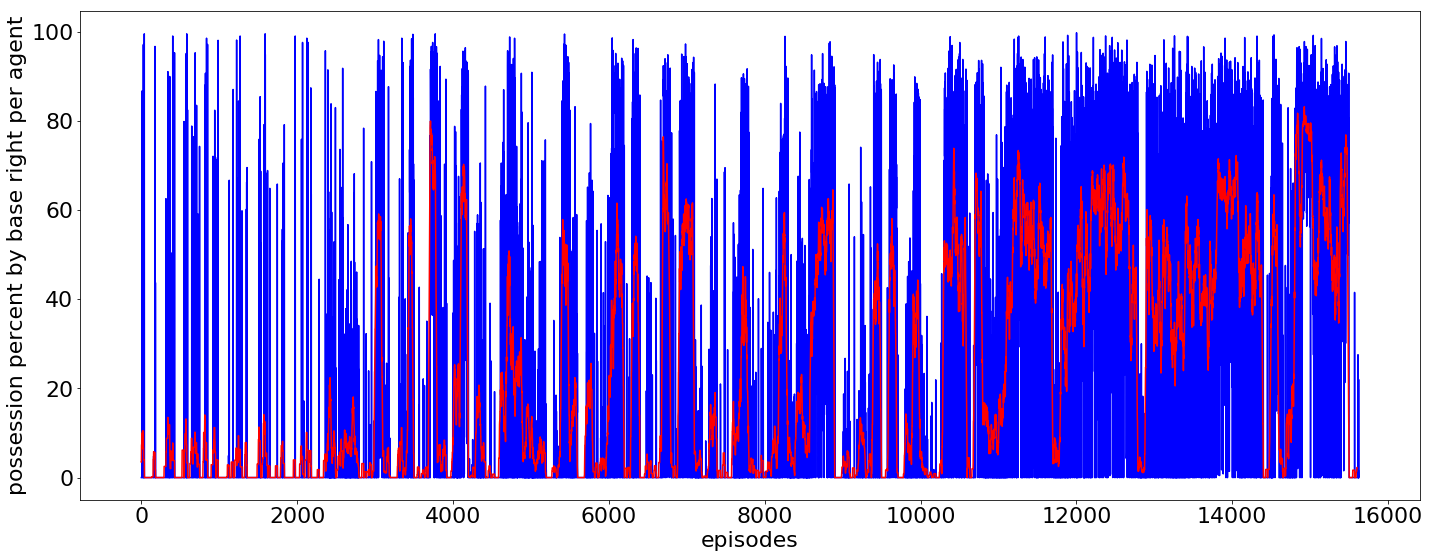

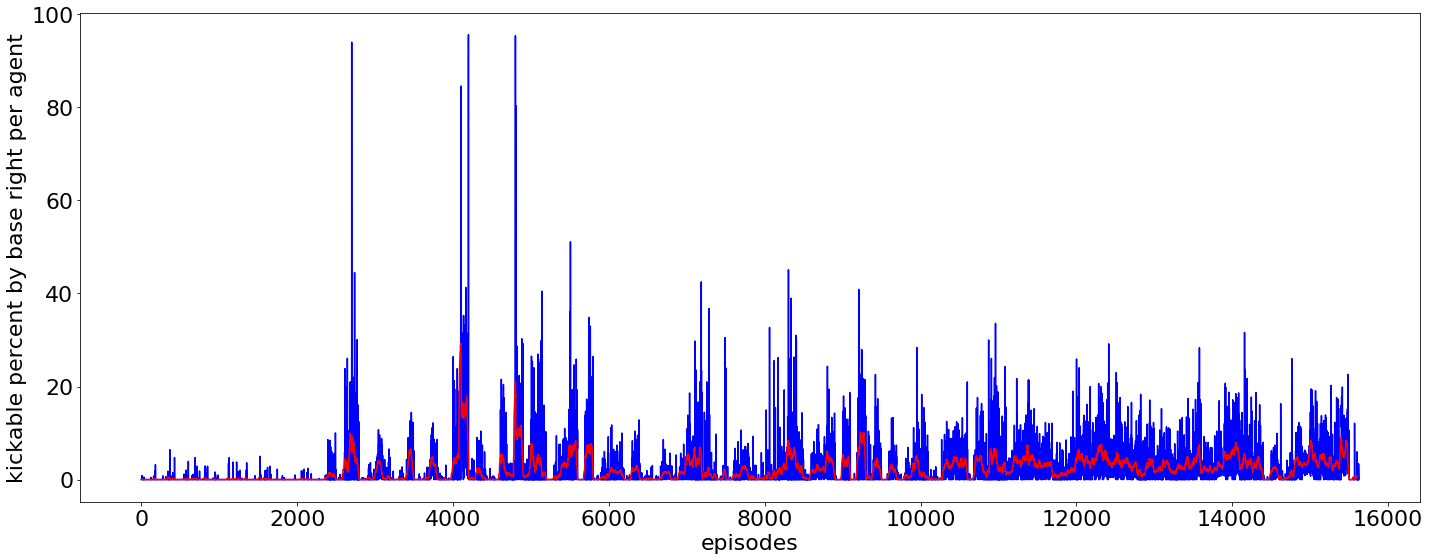

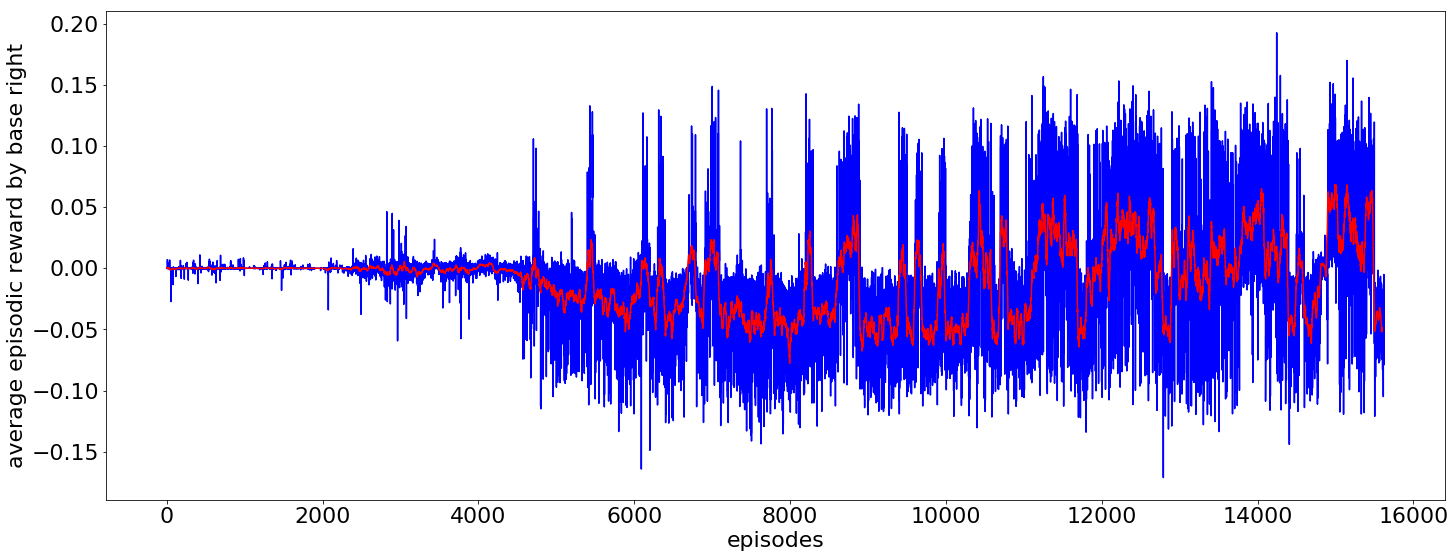

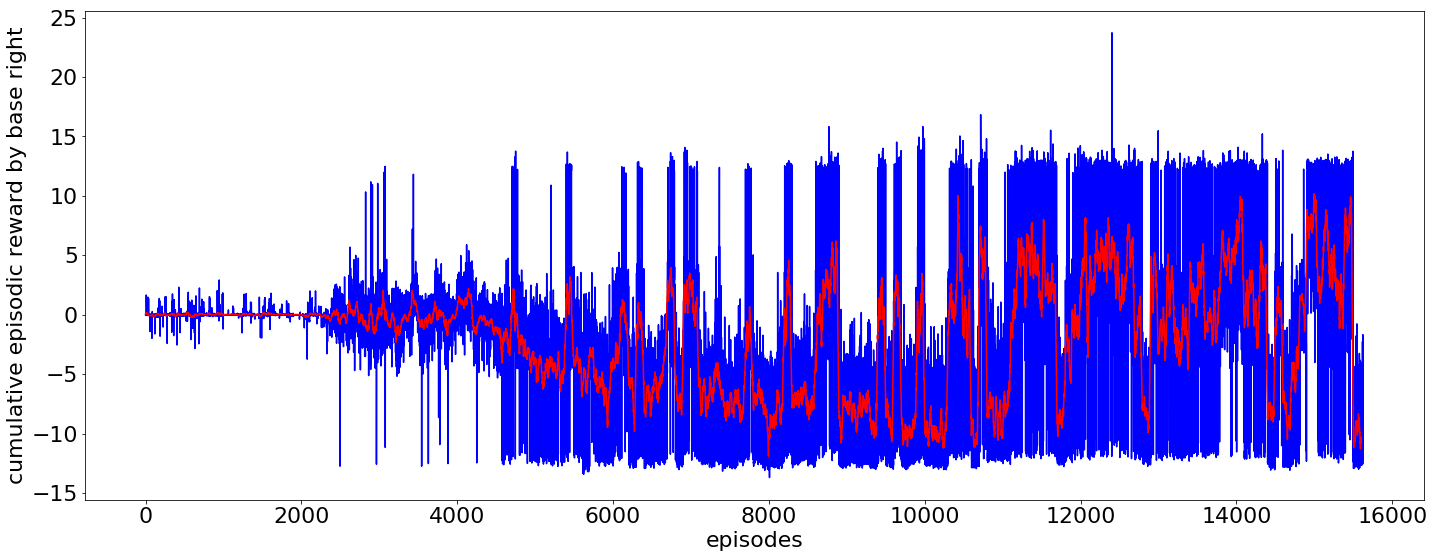

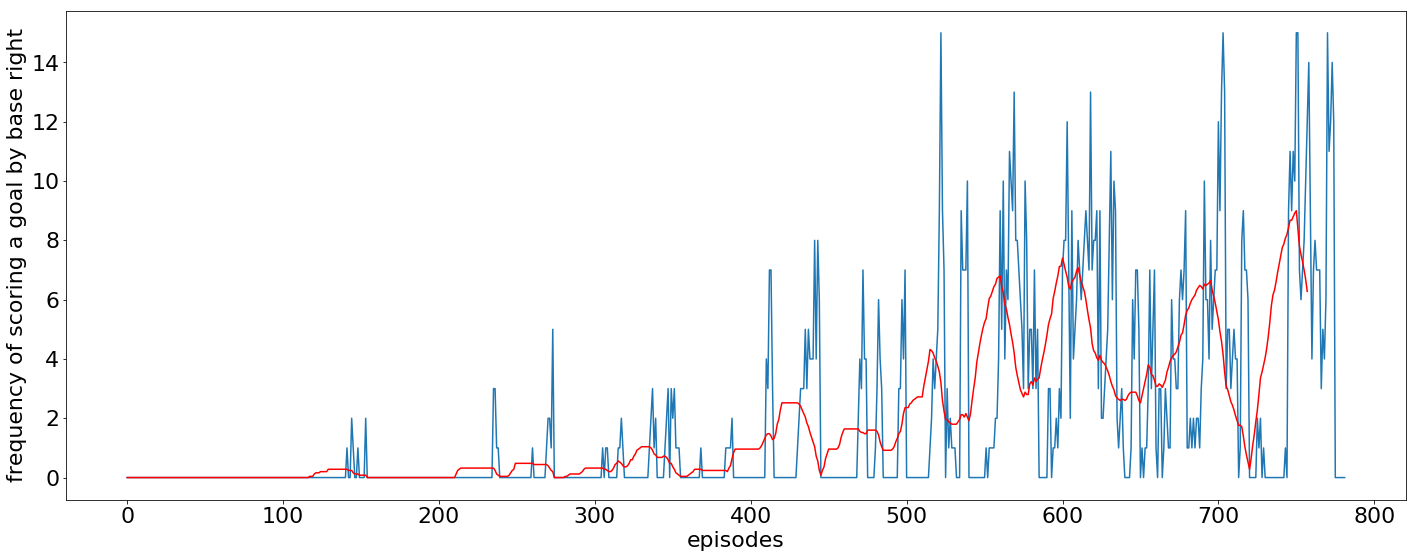

In [546]:
# Most recently created folder
data = pd.read_csv(training_path + '/history/team_history.csv', index_col=0)

# Manual input
# data = pd.read_csv('training_sessions/12_5_14_2_vs_2/history/team_history.csv')

print('number of episodes finished %d'%len(data))

print('number of time-steps finished %d'%(len(data)*500))

print(data.why.value_counts())


######################################---ball possession  and smoothed curve---#########################################################

# plt.rcParams.update({'font.size': 22})
# plt.figure(figsize=(24,9))
# plt.plot(data.team_kickable_percentages  )
# plt.plot( np.convolve(data.team_kickable_percentages,
#                       np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
# plt.xlabel('episodes')
# plt.ylabel('Ball possession by base left')
# plt.show()

######################################---ball possession  and smoothed curve---#########################################################
team_possession_percent = []
summed_percent = np.zeros(len(data))

for j in range(number_of_players):
    player_percent = []
    for i in range(len(data)):
        player_percent.append(literal_eval(data.possession_percentages[i])[j])
    team_possession_percent.append(player_percent)
    summed_percent = list(map(add, summed_percent, player_percent))

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
for k in range(number_of_players):
    plt.plot(team_possession_percent[k], color_palette[k])
plt.plot( np.convolve(np.ravel(summed_percent),
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('possession percent by base left per agent')
plt.show()

######################################---kickable percent per agent and smoothed curve---#########################################################

team_kickable_percent = []
summed_percent = np.zeros(len(data))

for j in range(number_of_players):
    player_percent = []
    for i in range(len(data)):
        player_percent.append(literal_eval(data.agents_kickable_percentages[i])[j])
    team_kickable_percent.append(player_percent)
    summed_percent = list(map(add, summed_percent, player_percent))

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
for k in range(number_of_players):
    plt.plot(team_kickable_percent[k], color_palette[k])
plt.plot( np.convolve(np.ravel(summed_percent),
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('kickable percent by base left per agent')
plt.show()

######################################--- average episodic reward and smoothed curve-----#########################################################



team_reward = []
summed_rew = np.zeros(len(data))

for j in range(number_of_players):
    player_reward = []
    for i in range(len(data)):
        player_reward.append(literal_eval(data.average_reward[i])[j])
    team_reward.append(player_reward)
    summed_rew = list( map(add, summed_rew,player_reward ) )

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
for k in range(number_of_players):
    plt.plot(team_reward[k], color_palette[k])
plt.plot( np.convolve(np.ravel(summed_rew) , 
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('average episodic reward by base left')
plt.show()

######################################--- cumulative episodic reward and smoothed curve-----#########################################################
team_reward = []
summed_rew = np.zeros(len(data))

for j in range(number_of_players):
    player_reward = []
    for i in range(len(data)):
        player_reward.append(literal_eval(data.cumulative_reward[i])[j])
    team_reward.append(player_reward)
    summed_rew = list( map(add, summed_rew,player_reward ) )
                 
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
for k in range(number_of_players):
    plt.plot(team_reward[k], color_palette[k])
plt.plot( np.convolve(np.ravel(summed_rew) ,
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('cumulative episodic reward by base left')
plt.show()

#####################################################


goal_freq = []
for i in range(0, len(data), goal_frequency_window):
    temp = data.loc[i:i+goal_frequency_window].why.value_counts()
    
    try: 
        goal_freq.append(temp.Goal_By_Left)
    except AttributeError:
        goal_freq.append(0)
        
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(goal_freq)
plt.plot( np.convolve(np.ravel(goal_freq) , 
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('frequency of scoring a goal by base left')
plt.show()


######################################--- team right data---#########################################################

# Most recently created folder
data = pd.read_csv(training_path + '/history/opp_history.csv', index_col=0)
# Manual input
# data = pd.read_csv('training_sessions/12_5_14_2_vs_2/history/opp_history.csv')

print('number of episodes finished %d'%len(data))

print('number of time-steps finished %d'%(len(data)*500))

    
#print(data.why.value_counts())

goal_frequency_window = 20

######################################---ball possession  and smoothed curve---#########################################################

# plt.rcParams.update({'font.size': 22})
# plt.figure(figsize=(24,9))
# plt.plot(data.team_kickable_percentages  )
# plt.plot( np.convolve(data.team_kickable_percentages, 
#                       np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
# plt.xlabel('episodes')
# plt.ylabel('Ball possession by base right')
# plt.show()

######################################---ball possession  and smoothed curve---#########################################################
team_possession_percent = []
summed_percent = np.zeros(len(data))

for j in range(number_of_players):
    player_percent = []
    for i in range(len(data)):
        player_percent.append(literal_eval(data.possession_percentages[i])[j])
    team_possession_percent.append(player_percent)
    summed_percent = list(map(add, summed_percent, player_percent))

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
for k in range(number_of_players):
    plt.plot(team_possession_percent[k], color_palette[k])
plt.plot( np.convolve(np.ravel(summed_percent),
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('possession percent by base right per agent')
plt.show()

######################################---kickable percent per agent and smoothed curve---#########################################################

team_kickable_percent = []
summed_percent = np.zeros(len(data))

for j in range(number_of_players):
    player_percent = []
    for i in range(len(data)):
        player_percent.append(literal_eval(data.agents_kickable_percentages[i])[j])
    team_kickable_percent.append(player_percent)
    summed_percent = list(map(add, summed_percent, player_percent))
    
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
for k in range(number_of_players):
    plt.plot(team_kickable_percent[k], color_palette[k])
plt.plot( np.convolve(np.ravel(summed_percent),
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('kickable percent by base right per agent')
plt.show()



######################################--- average episodic reward and smoothed curve-----#########################################################


team_reward = []
summed_rew = np.zeros(len(data))

for j in range(number_of_players):
    player_reward = []
    for i in range(len(data)):
        player_reward.append(literal_eval(data.average_reward[i])[j])
    team_reward.append(player_reward)
    summed_rew = list( map(add, summed_rew,player_reward ) )

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
for k in range(number_of_players):
    plt.plot(team_reward[k], color_palette[k])
plt.plot( np.convolve(np.ravel(summed_rew) ,
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('average episodic reward by base right')
plt.show()

######################################--- cumulative episodic reward and smoothed curve-----#########################################################
team_reward = []
summed_rew = np.zeros(len(data))

for j in range(number_of_players):
    player_reward = []
    for i in range(len(data)):
        player_reward.append(literal_eval(data.cumulative_reward[i])[j])
    team_reward.append(player_reward)
    summed_rew = list( map(add, summed_rew,player_reward ) )
                 
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
for k in range(number_of_players):
    plt.plot(team_reward[k], color_palette[k])
plt.plot( np.convolve(np.ravel(summed_rew) , 
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('cumulative episodic reward by base right')
plt.show()

#####################################################

goal_freq = []
for i in range(0, len(data), goal_frequency_window):
    temp = data.loc[i:i+goal_frequency_window].why.value_counts()
    
    try: 
        goal_freq.append(temp.Goal_By_Right)
    except AttributeError:
        goal_freq.append(0)
        
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(goal_freq)
plt.plot( np.convolve(np.ravel(goal_freq) , 
                      np.ones((moving_average_window,))/moving_average_window, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('frequency of scoring a goal by base right')
plt.show()

In [527]:
csv_path = training_path + '/eval_history/'
csv_list = [x[0] for x in sorted([(fn, os.stat(csv_path + fn)) for fn in os.listdir(csv_path)], key = lambda x: x[1].st_ctime)]
print(csv_list)

[]


In [475]:
del csv_list[5]

number of episodes finished 120
number of time-steps finished 60000
OutOfTime    120
Name: why, dtype: int64


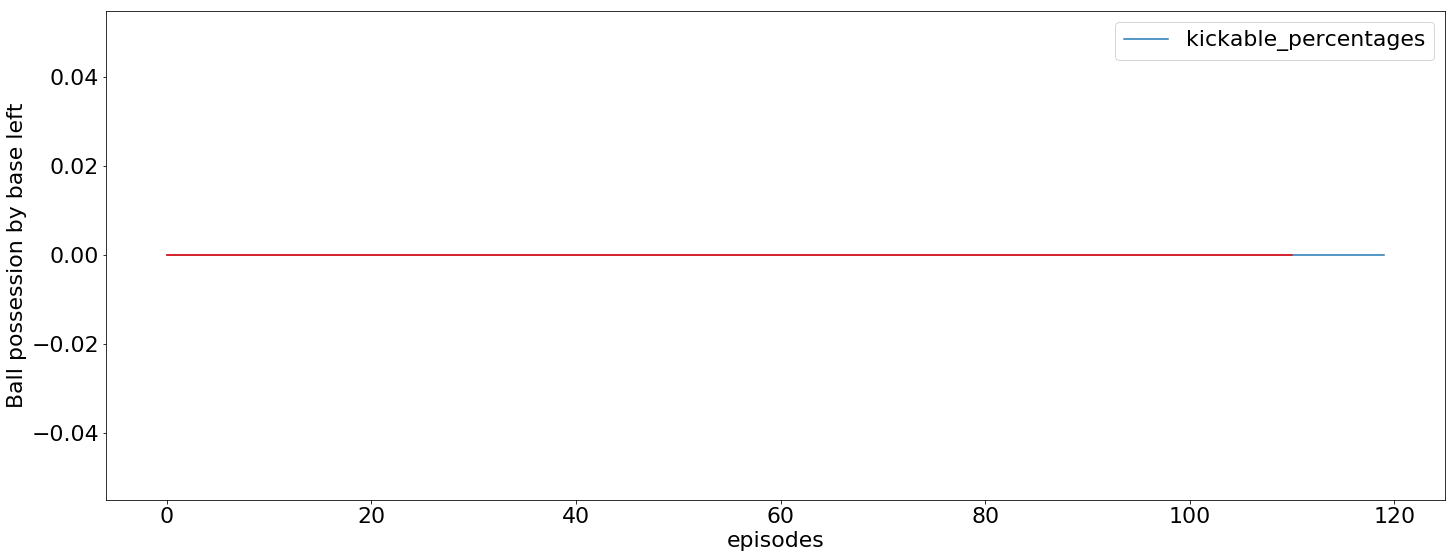

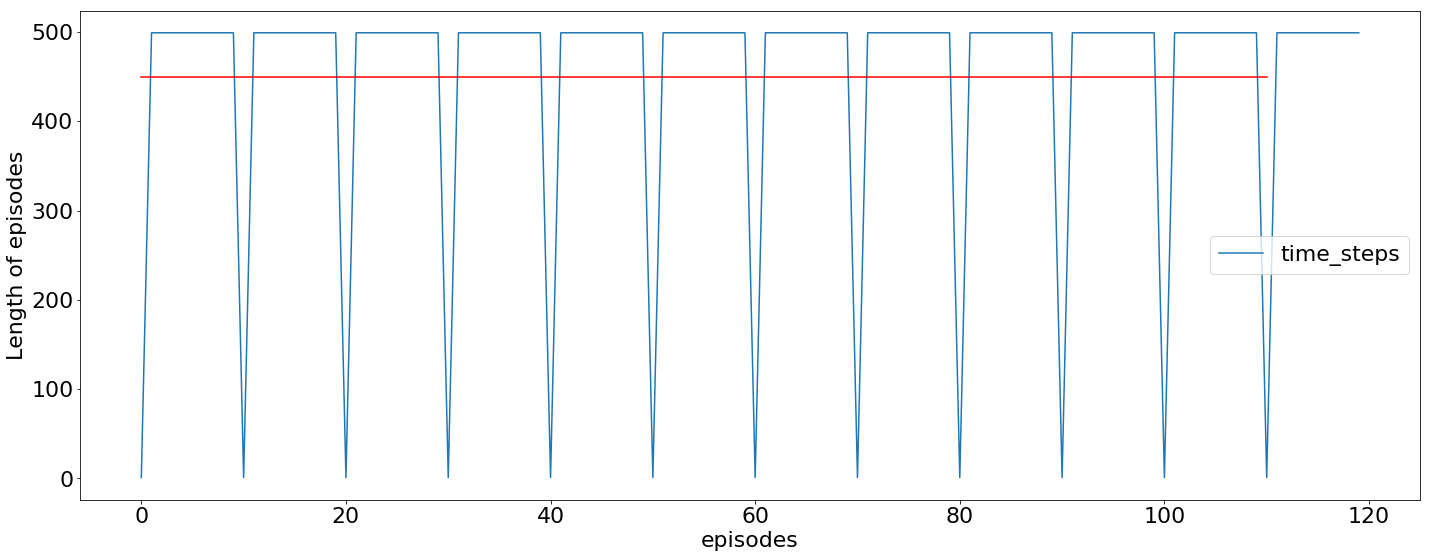

No handles with labels found to put in legend.


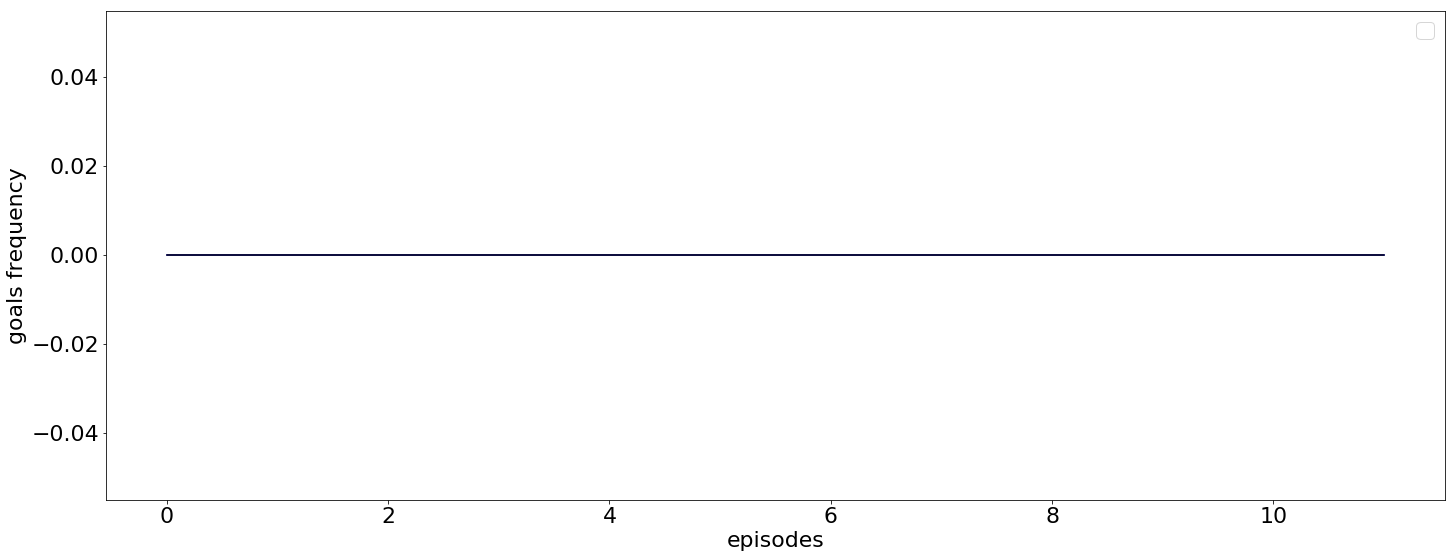

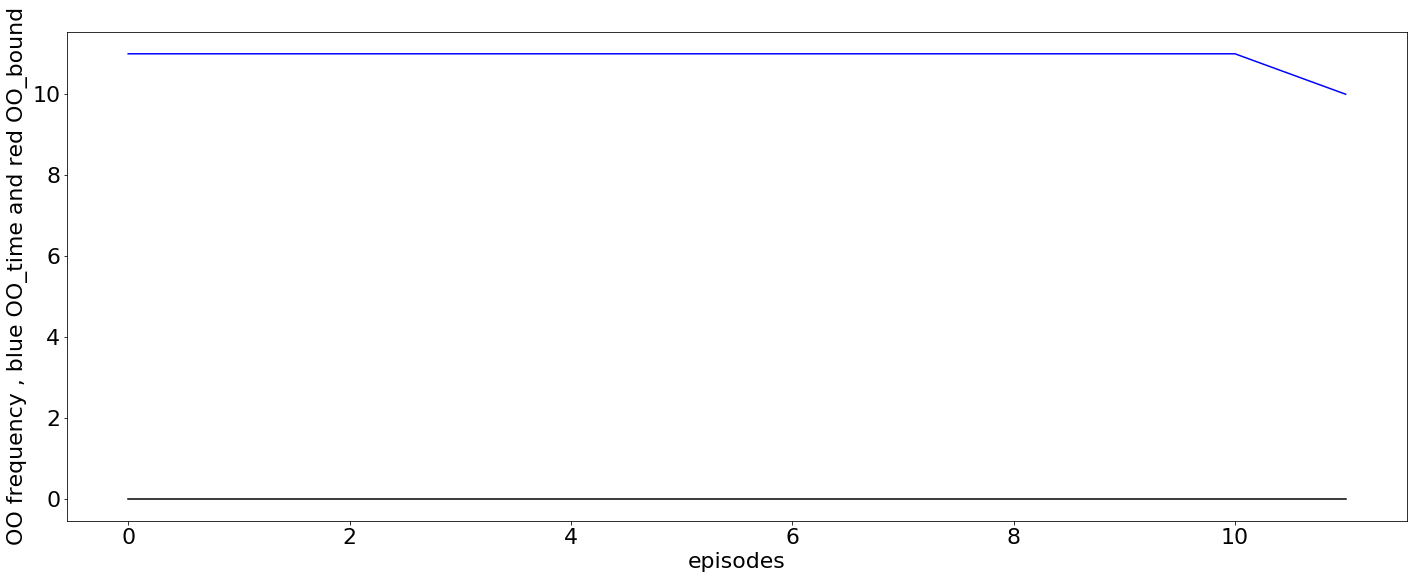

In [476]:
df_list = [pd.read_csv(csv_path + file, index_col=0) for file in csv_list]
data = pd.concat(df_list, ignore_index=True)
# data = pd.read_csv('training_sessions/12_5_14_2_vs_2/eval_history/evaluation_ep10.csv')

print('number of episodes finished %d'%len(data))

print('number of time-steps finished %d'%(len(data)*500))

    
print(data.why.value_counts())


######################################---ball possession  and smoothed curve---#########################################################

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(data.kickable_percentages)
moving_average = np.convolve(data.kickable_percentages, np.ones((10,))/10, mode='valid')
plt.plot( moving_average, '-r' )
plt.legend()
plt.xlabel('episodes')
plt.ylabel('Ball possession by base left')
plt.show()

######################################---episode time---#########################################################

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(data.time_steps)
plt.plot( np.convolve(data.time_steps, np.ones((10,))/10, mode='valid'), '-r' )
plt.legend()
plt.xlabel('episodes')
plt.ylabel('Length of episodes')
plt.show()


######################################--- why freq graphs-----#########################################################

goal_by_left_freq = []
goal_by_right_freq = []
OOT_freq = []
OOB_freq = []
for i in range(0, len(data), frequency_window):
    temp = data.loc[i:i+frequency_window].why.value_counts()
    
    try: 
        goal_by_left_freq.append(temp.Goal_By_Left)
    except AttributeError:
        goal_by_left_freq.append(0)
    
    try: 
        goal_by_right_freq.append(temp.Goal_By_Right)
    except AttributeError:
        goal_by_right_freq.append(0)
    
    try: 
        OOT_freq.append(temp.OutOfTime)
    except AttributeError:
        OOT_freq.append(0)
    
    try: 
        OOB_freq.append(temp.OutOfBounds)
    except AttributeError:
        OOB_freq.append(0)
        
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(goal_by_left_freq, '-b')
#plt.plot( np.convolve(np.ravel(goal_by_left_freq) , np.ones((10,))/10, mode='valid'), '-r' )
plt.plot(goal_by_right_freq, '-k')
#plt.plot( np.convolve(np.ravel(goal_by_right_freq) , np.ones((10,))/10, mode='valid'), '-g' )
plt.legend()
plt.xlabel('episodes')
plt.ylabel('goals frequency')
plt.show()

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(OOT_freq, '-b')
#plt.plot( np.convolve(np.ravel(OOT_freq) , np.ones((10,))/10, mode='valid'), '-r' )
plt.plot(OOB_freq, '-k')
#plt.plot( np.convolve(np.ravel(OOB_freq) , np.ones((10,))/10, mode='valid'), '-g' )
plt.xlabel('episodes')
plt.ylabel('OO frequency , blue OO_time and red OO_bound')
plt.show()